In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
import json
import time
import os
import sys
sys.path.append("../..")
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

import scipy
from scipy.stats import sem
from scipy.io import loadmat

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import tensorflow as tf
import gpflow

from tqdm.notebook import tqdm
import geopandas as gpd
from shapely.geometry import Polygon, Point
import contextily as ctx
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [14]:
# Load the data. Please email the corresponding author for access to the data.

data = loadmat('../../data/dr_paper/EVIVOD_Zhu.mat')
lonLat = loadmat('../../data/dr_paper/latlon_allcrops.mat', squeeze_me=True)

## Data Processing

In [15]:
df = gpd.GeoDataFrame(pd.DataFrame(np.zeros((data["data"]["Y"][0][0].shape[0], 1)), columns=["yield"]))
df["yield"] = data["data"]["Y"][0][0][:,0]
df.crs = {'init':"epsg:4326"}

<ipython-input-15-ac4b3f930132>:3: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  df.crs = {'init':"epsg:4326"}
/home/hbz15/.local/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [16]:
# Check which counties are Polygons

geometry = []
for i in range(385):
    if type(lonLat["lon_county"][i][0]) == np.float64:
        length = 1
    else:
        length = lonLat["lon_county"][i][0].shape[0]
    if length == 1:
        polygon_geom = Point(lonLat["lon_county"][i][0], lonLat["lat_county"][i][0])
    else:
        polygon_geom = Polygon(zip(lonLat["lon_county"][i][0][:-1], lonLat["lat_county"][i][0][:-1]))
    geometry.append(polygon_geom)
# plt.colorbar()

In [17]:
# Only use data presented in Polygon type

df.geometry = geometry
df["type"] = df["geometry"].apply(lambda v: isinstance(v, Polygon))
df = df[df["type"]]

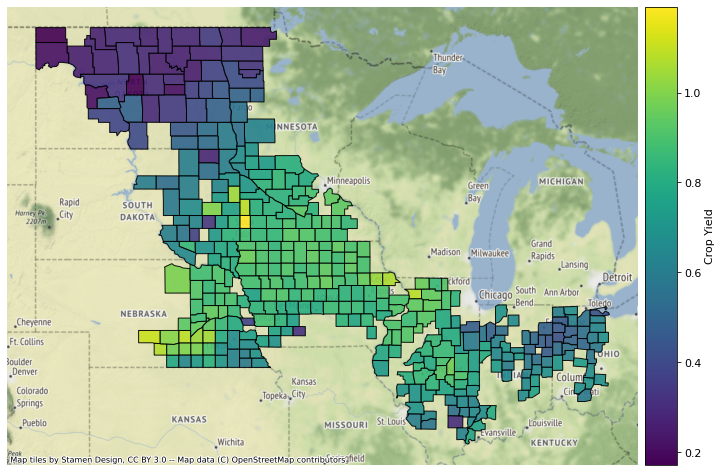

In [18]:
df_plot = df.to_crs(epsg=3857)
pars = {"size": 11}
plt.rc("font", **pars)
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
df_plot.plot(column="yield", ax=ax,
            edgecolor='k', cmap="viridis", alpha=0.9,legend=True, cax=cax, legend_kwds={'label': 'Crop Yield'})
ax.set_aspect("equal")
# ax1.set_xlim([-1.04e7, -0.94e7])
ctx.add_basemap(ax)
ax.axis('off')
fig.savefig(f"../../results/dr_paper/data_dr.pdf", bbox_inches="tight")

In [25]:
def random_points_in_polygon(number, polygon):
    """Sample uniformly in a polygon
    
    """
    points = []
    min_x, min_y, max_x, max_y = polygon.bounds
    i= 0
    while i < number:
        long = random.uniform(min_x, max_x)
        lat = random.uniform(min_y, max_y)
        point = Point(long, lat)
        if polygon.contains(point):
            points.append([long, lat])
            i += 1
    return points # returns list of shapely point

In [26]:
print(polygon_geom.exterior.coords.xy)

(array('d', [-97.637496, -97.399191, -97.160544, -97.16054299999999, -97.16036, -97.1650703923738, -97.213957, -97.23786799999999, -97.302075, -97.34118099999999, -97.41706599999999, -97.45217699999999, -97.48491687634201, -97.515948, -97.59926, -97.6354420904415, -97.637496]), array('d', [43.168769999999995, 43.169419, 43.169978, 43.083144999999995, 42.811795, 42.7916166414677, 42.820142999999995, 42.853139, 42.86566, 42.855882, 42.865918, 42.846047999999996, 42.850003214867904, 42.853752, 42.856229, 42.85180907518549, 43.168769999999995]))


In [27]:
df["county"] = df.index

In [28]:
df["geometry"]

0      POLYGON ((-91.50617 40.20064, -90.91197 40.193...
1      POLYGON ((-88.94038 42.49544, -88.77650 42.494...
2      POLYGON ((-89.86235 41.58400, -89.63149 41.584...
3      POLYGON ((-90.31570 42.19395, -89.91965 42.196...
4      POLYGON ((-88.46317 40.14220, -88.46042 40.281...
                             ...                        
379    POLYGON ((-98.33204 44.19662, -97.85366 44.195...
380    POLYGON ((-98.71776 45.24373, -97.98146 45.240...
381    POLYGON ((-97.40145 43.49978, -97.12948 43.499...
382    POLYGON ((-96.80568 43.08367, -96.45210 43.082...
384    POLYGON ((-97.63750 43.16877, -97.39919 43.169...
Name: geometry, Length: 375, dtype: geometry

In [29]:
df[df.index==330]

,yield,geometry,type,county
330,0.503588,"POLYGON ((-83.88006 40.81992, -83.51588 40.818...",True,330


In [30]:
# gpd.GeoDataFrame(df).to_file("../../data/dr_paper/final_geometry.shp")

## Calculate the max number of items in a bag

In [31]:
max_VOD = 0
max_EVI = 0
for i in df.index.values:
    if type(data["data"]["EVI"][0][0][i][0]) == np.float64:
        EVI_length = 1
    else:
        EVI_length = data["data"]["EVI"][0][0][i][0][:-1].shape[0]
        
    if type(data["data"]["VOD"][0][0][i][0]) == np.float64:
        VOD_length = 1
    else:
        VOD_length = data["data"]["VOD"][0][0][i][0][:-1].shape[0]
    max_EVI = max(max_EVI, EVI_length)
    max_VOD = max(max_VOD, VOD_length)
#     print(EVI_length, VOD_length)
dim_VOD = 213
dim_EVI = 13

## Read out the dataset from the `.mat` file and put into a dictionary with keys being the bag

In [32]:
def create_spatial_data_dict(data, df, indices, max_VOD, max_EVI, space_length=100):
    """Put the dataset into a dictionary by:

    - Concatenating the EVI and VOD covariates
    - Add in another set of spatial covariates of length space_length
    - Setting weights to be $1/N_a$ - uniform weights

    """
    dict_data = {}

    for i in tqdm(indices):
        x_VOD = np.zeros((max_VOD, 213))
        x_EVI = np.zeros((max_EVI, 13))
        if type(data["data"]["EVI"][0][0][i][0]) == np.float64:
            x_EVI[:1] = data["data"]["EVI"][0][0][i][0, :13]
            EVI_length = 1
        else:
            EVI_length = int(data["data"]["EVI"][0][0][i][0][:-1].shape[0])
            x_EVI[:EVI_length] = data["data"]["EVI"][0][0][i][0][:-1, :13]
            
        if type(data["data"]["VOD"][0][0][i][0]) == np.float64:
            x_VOD[:1] = data["data"]["VOD"][0][0][i][0][:, :213]
            VOD_length = 1
        else:
            VOD_length = int(data["data"]["VOD"][0][0][i][0][:-1].shape[0])
            x_VOD[:VOD_length] = data["data"]["VOD"][0][0][i][0][:-1, :213]

        x_space = np.array(random_points_in_polygon(space_length, df.geometry[i]))
            
        weights_VOD = np.zeros((max_VOD, 1))
        weights_EVI = np.zeros((max_EVI, 1))
        weights_VOD[: VOD_length, 0] = 1/VOD_length
        weights_EVI[: EVI_length, 0] = 1/EVI_length
        y = data["data"]["Y"][0][0][i][0]

        dict_data[str(i)] = {
            "space_length": space_length,
            "N": VOD_length,
            "weights_space": np.expand_dims(np.array([1 / space_length] * space_length), axis=1),
            "w": weights_VOD,
            "x_space": x_space,
            "x": np.concatenate([x_VOD, x_EVI], axis=1),
            "y": np.expand_dims(y, 0),        
        }
    return dict_data

## Shuffle the county index

In [33]:
indices = list(df.index.values)
random.seed(1)
shuffled_indices = random.sample(indices, 375)

In [34]:
geom = df.geometry[0]

## S-KRR Experiments

In [35]:
from src.bagData import BagData, BagDataGenerator
from typing import Callable
from sklearn.cluster import KMeans

class MultiResolutionBagData(BagData):
    """
    """

    def __init__(self, bag_data: dict) -> None:
        super().__init__(bag_data)
        
    def _create_subset(
        self, initial_num_items: int, initialisationMethod: Callable = None
    ) -> None:

        raise NotImplementedError()
    def __getitem__(self, bag):
        """
            bag: bag index from indexing system
        """
        return (
            self.bag_data[bag]["space_length"],
            self.bag_data[bag]["N"],
            self.bag_data[bag]["weights_space"],
            self.bag_data[bag]["w"],
            self.bag_data[bag]["x_space"],
            self.bag_data[bag]["x"],
            self.bag_data[bag]["y"],
        )

class MultiResolutionBagDataGenerator(MultiResolutionBagData):
    def __init__(self, bag_data: dict, num_inducing_us: int = 1, num_inducing_u1: int = 1, num_inducing_u2: int = 1) -> None:
        super().__init__(bag_data)
        self.num_inducing_us = num_inducing_us
        self.num_inducing_u1 = num_inducing_u1
        self.kmeans_s = KMeans(n_clusters=num_inducing_us)
        self.kmeans_1 = KMeans(n_clusters=num_inducing_u1)
        self.dim_space = 2
        self.dim_1 = self.__getitem__(self.bags[0])[-2].shape[1]

    def gen_bags(self):
        for bag in self.bags:
            yield self.__getitem__(bag)


## S-MVBAgg Experiments

In [36]:
def run_adam(model, test_bag, ds_train, iterations, N, minibatch_size = 50):
    """
    Utility function running the Adam optimizer
    Modified from https://gpflow.readthedocs.io/en/master/notebooks/advanced/gps_for_big_data.html

    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    train_iter = iter(ds_train.repeat().shuffle(N).batch(minibatch_size))
    training_loss = model.training_loss_closure(train_iter, compile=True)
    optimizer = tf.optimizers.Adam()

    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)

    for step in tqdm(range(iterations)):
        optimization_step()
        if step % (N // minibatch_size) == 0:
            elbo = -training_loss().numpy()
            logf.append(elbo)
            
        if step % 1000 == 0:
            y_pred, _ = pred_bag(model, test_bag)
#             print(f"EPOCH: {step}, ELBO: {elbo}, Noise: {m.likelihood.variance.numpy()}")
            print(f"EPOCH: {step}, ELBO: {elbo}, Test RMSE: {np.sqrt(np.mean((y_pred - test_bag.y[:, 0]) ** 2))}\
            MAPE: {np.mean(np.abs(( y_pred - test_bag.y[:, 0] ) / test_bag.y[:, 0]))}")
    return logf


def pred_bag(m, test_bag):

    y_pred = np.zeros(test_bag.num_bags)
    y_std = np.zeros(test_bag.num_bags)
    for i, bag in enumerate(test_bag.bags):
        mean_pred = m.predict_f(np.expand_dims(test_bag[bag][2], axis=0),
                                np.expand_dims(test_bag[bag][4], axis=0), 
                                np.expand_dims(test_bag[bag][3], axis=0), 
                                np.expand_dims(test_bag[bag][5], axis=0))
        y_pred[i] = mean_pred[0]
        y_std[i] = np.sqrt(mean_pred[1])
    return y_pred, y_std

In [37]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


Num GPUs Available:  2



Calculating Inducing Points



Begin Training


EPOCH: 0, ELBO: -790.8041722528422, Test RMSE: 0.7603763343468273            MAPE: 0.995283647911589
EPOCH: 1000, ELBO: -323.9353532072363, Test RMSE: 0.08082354794888404            MAPE: 0.08125413531024672
EPOCH: 2000, ELBO: -170.48002672991683, Test RMSE: 0.061937668099352874            MAPE: 0.06594344510305221
EPOCH: 3000, ELBO: -12.645824611246503, Test RMSE: 0.056311726768722405            MAPE: 0.060419502013561346
EPOCH: 4000, ELBO: 110.39725187370628, Test RMSE: 0.05455400910627783            MAPE: 0.060085086099346416
EPOCH: 5000, ELBO: 251.93016342366144, Test RMSE: 0.05467500839100416            MAPE: 0.06046053850548868
EPOCH: 6000, ELBO: 274.6790886109921, Test RMSE: 0.0550209202589751            MAPE: 0.056677833852970136
EPOCH: 7000, ELBO: 345.5465720473016, Test RMSE: 0.0537400814797019            MAPE: 0.059245509960866596
EPOCH: 8000, ELBO: 365.2124418869445, Test RMSE: 0.05336233105660567            MAPE: 0.057178271067266806
EPOCH: 9000, ELBO: -120.44898511297737,


Calculating Inducing Points



Begin Training


EPOCH: 0, ELBO: -777.5205629005, Test RMSE: 0.7716734115858979            MAPE: 0.9954647300038173
EPOCH: 1000, ELBO: -315.75901977054514, Test RMSE: 0.09171403169053471            MAPE: 0.07974065126272821
EPOCH: 2000, ELBO: -159.46957706954845, Test RMSE: 0.0830148251359915            MAPE: 0.06921203800919655
EPOCH: 3000, ELBO: 0.7428391837376509, Test RMSE: 0.08299253480576518            MAPE: 0.06645658687231712
EPOCH: 4000, ELBO: 126.15686570360027, Test RMSE: 0.0819108598841047            MAPE: 0.0664122100601333
EPOCH: 5000, ELBO: 242.50867115983, Test RMSE: 0.0802094739091381            MAPE: 0.06624622659911844
EPOCH: 6000, ELBO: 332.1760613342797, Test RMSE: 0.07911850541290093            MAPE: 0.06873910420444318
EPOCH: 7000, ELBO: 349.4721356630387, Test RMSE: 0.07821834573264519            MAPE: 0.0679328492096661
EPOCH: 8000, ELBO: 332.8389028311318, Test RMSE: 0.07753228413569968            MAPE: 0.06934298727553417
EPOCH: 9000, ELBO: -78.65788197477576, Test RMSE: 0.07


Calculating Inducing Points



Begin Training


EPOCH: 0, ELBO: -812.8485495233998, Test RMSE: 0.7060266161661783            MAPE: 0.9953294489169732
EPOCH: 1000, ELBO: -328.50776513865105, Test RMSE: 0.08320431042808991            MAPE: 0.1125238547196852
EPOCH: 2000, ELBO: -170.1693137720971, Test RMSE: 0.08033487909912937            MAPE: 0.1027809274682655
EPOCH: 3000, ELBO: -1.4306201773077554, Test RMSE: 0.07978152563234919            MAPE: 0.09921081671227916
EPOCH: 4000, ELBO: 143.1241207375163, Test RMSE: 0.07907472682353951            MAPE: 0.09677178942771482
EPOCH: 5000, ELBO: 272.6721231753867, Test RMSE: 0.07990279456291141            MAPE: 0.0966796347749844
EPOCH: 6000, ELBO: 341.6390597828836, Test RMSE: 0.0767307240635845            MAPE: 0.09070008967556664
EPOCH: 7000, ELBO: 332.5420213091269, Test RMSE: 0.0797749826570395            MAPE: 0.09472669005633816
EPOCH: 8000, ELBO: 392.6405065112098, Test RMSE: 0.07829732491021414            MAPE: 0.09268509547157643
EPOCH: 9000, ELBO: 354.77044405156, Test RMSE: 0.0


Calculating Inducing Points



Begin Training


EPOCH: 0, ELBO: -788.643438124059, Test RMSE: 0.7626784394342645            MAPE: 0.9953992963785636
EPOCH: 1000, ELBO: -316.8913044051402, Test RMSE: 0.0934496146240606            MAPE: 0.09357693047978391
EPOCH: 2000, ELBO: -171.79143438163123, Test RMSE: 0.07505285905469396            MAPE: 0.08000074082973073
EPOCH: 3000, ELBO: -24.249030356006894, Test RMSE: 0.0720911256548044            MAPE: 0.07941884674504492
EPOCH: 4000, ELBO: 143.39327914962757, Test RMSE: 0.0688044291110726            MAPE: 0.07640290063594968
EPOCH: 5000, ELBO: 227.21537661670288, Test RMSE: 0.06969315226404726            MAPE: 0.07257438034022377
EPOCH: 6000, ELBO: 335.9090777674654, Test RMSE: 0.06898666405461953            MAPE: 0.07142339313361759
EPOCH: 7000, ELBO: 370.5140186594348, Test RMSE: 0.06914709444690587            MAPE: 0.07259724672859
EPOCH: 8000, ELBO: 370.6389838840984, Test RMSE: 0.06795447142312193            MAPE: 0.0722496442996387
EPOCH: 9000, ELBO: 382.7924233949105, Test RMSE: 0.


Calculating Inducing Points



Begin Training


EPOCH: 0, ELBO: -779.4952578778116, Test RMSE: 0.7049129793513368            MAPE: 0.9958598545521578
EPOCH: 1000, ELBO: -316.7738540523907, Test RMSE: 0.10034043170227747            MAPE: 0.12080726340411944
EPOCH: 2000, ELBO: -176.6074033036517, Test RMSE: 0.09034741449438183            MAPE: 0.10536316978155585
EPOCH: 3000, ELBO: -3.607576888515581, Test RMSE: 0.08805372223450039            MAPE: 0.10153038057903255
EPOCH: 4000, ELBO: 122.10268380791084, Test RMSE: 0.08694542507274566            MAPE: 0.09948412965112423
EPOCH: 5000, ELBO: 13.931517782007674, Test RMSE: 0.08478360055432894            MAPE: 0.09422395388800747
EPOCH: 6000, ELBO: 335.9840112085933, Test RMSE: 0.08267927883382424            MAPE: 0.0906462475990481
EPOCH: 7000, ELBO: -83.67125326909904, Test RMSE: 0.08228066258696486            MAPE: 0.09047015018969277
EPOCH: 8000, ELBO: -136.23118440666653, Test RMSE: 0.08121710905338338            MAPE: 0.08776397441466642
EPOCH: 9000, ELBO: 386.57671639345153, Test

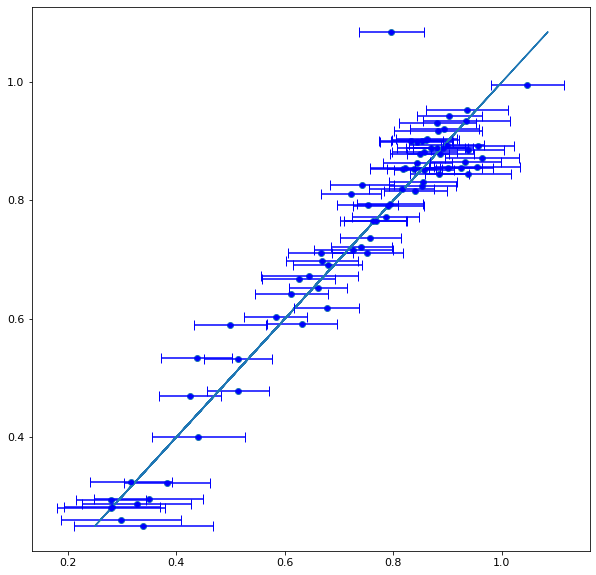

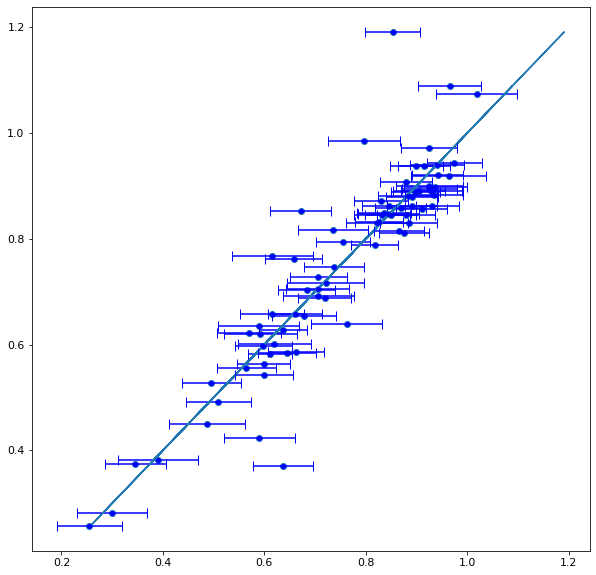

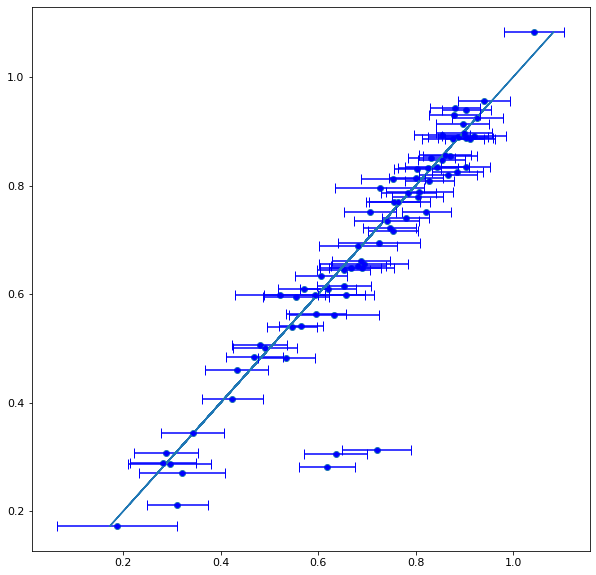

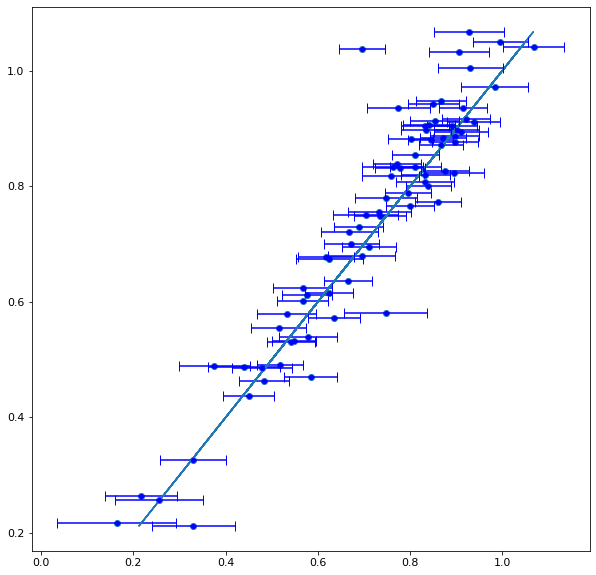

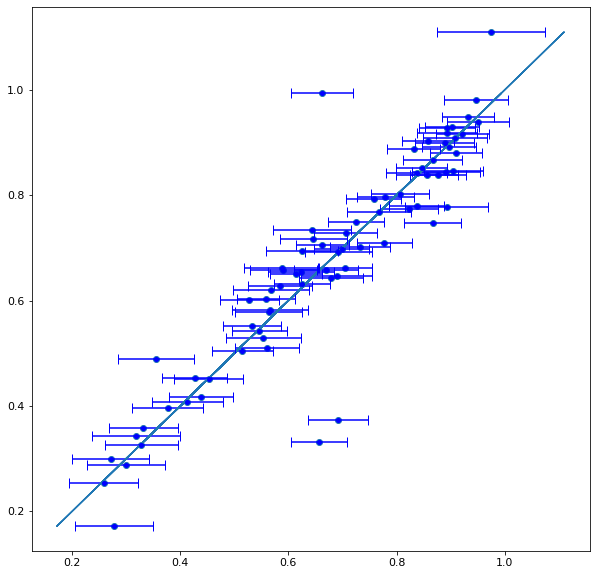

In [38]:
from src.svgp import MultiResolutionVBagg
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

RMSE = []
MAPE = []
training_time = []
for k in range(5):
    train_indices = shuffled_indices[:k*75] + shuffled_indices[(k+1)*75:]
    test_indices = shuffled_indices[k*75: (k+1)*75]
    train_set = create_spatial_data_dict(data, df, train_indices, max_VOD, max_EVI)
    test_set = create_spatial_data_dict(data, df, test_indices, max_VOD, max_EVI)

    ## SVGP
    train_bag = MultiResolutionBagDataGenerator(train_set)

    # initialise by 1 element from each bag
    zs = np.zeros((train_bag.num_bags, train_bag.dim_space))
    z1 = np.zeros((train_bag.num_bags, train_bag.dim_1))
    kmeanss = KMeans(n_clusters=1)
    kmeans1 = KMeans(n_clusters=1)
    print("Calculating Inducing Points")
    for i, bag in tqdm(enumerate(train_bag.bags)):
        zs[i, :] = kmeanss.fit(train_bag[bag][4][:train_bag[bag][0]]).cluster_centers_
        z1[i, :] = kmeans1.fit(train_bag[bag][5][:train_bag[bag][1]]).cluster_centers_
    
    ks = gpflow.kernels.Matern32()
    k1 = gpflow.kernels.SquaredExponential(active_dims=[i for i in range(213)])
    k2 = gpflow.kernels.SquaredExponential(active_dims=[i for i in range(213, 226)])
    ds_train = tf.data.Dataset.from_generator(
        train_bag.gen_bags, 
        output_types=(
            tf.int64, 
            tf.int64, 
            tf.float64, 
            tf.float64, 
            tf.float64, 
            tf.float64, 
            tf.float64
        )
    )
    m = MultiResolutionVBagg((ks, k1+k2), gpflow.likelihoods.Gaussian(), z1=zs, z2=z1,num_data=train_bag.num_bags)

    # We turn off training for inducing point locations
    gpflow.set_trainable(m.z1, False)
    gpflow.set_trainable(m.z2, False)

    test_bag = MultiResolutionBagDataGenerator(test_set)
    
    maxiter = 20000
    print("Begin Training")
    t0 = time.time()
    logf = run_adam(m, test_bag, ds_train, N=train_bag.num_bags, iterations=maxiter, minibatch_size=5)
    t1 = time.time()
    
    y_pred = np.zeros(test_bag.num_bags)
    y_std = np.zeros(test_bag.num_bags)
    for i, bag in enumerate(test_set.keys()):
        mean_pred = m.predict_f(np.expand_dims(test_bag[bag][2], axis=0),
                                np.expand_dims(test_bag[bag][4], axis=0), 
                                np.expand_dims(test_bag[bag][3], axis=0), 
                                np.expand_dims(test_bag[bag][5], axis=0))
        y_pred[i] = mean_pred[0]
        y_std[i] = np.sqrt(mean_pred[1])
    lower = np.reshape(1.96 * y_std, (test_bag.num_bags, 1))
    upper = np.reshape(1.96 * y_std, (test_bag.num_bags, 1))
    print(lower.shape, upper.shape)
    errors = np.concatenate((lower, upper), axis=1)
    errors = errors.T


    # plot predictions out-of-sample and save them
    plt.figure(figsize=(10, 10))
    plt.scatter(y_pred, test_bag.y)
    plt.plot(test_bag.y, test_bag.y)
    MAPE.append(np.mean(np.abs(( y_pred - test_bag.y[:, 0] ) / test_bag.y[:, 0])))
    RMSE.append(np.sqrt(np.mean((y_pred - test_bag.y[:, 0]) ** 2)))
    training_time.append(t1-t0)
    
    plt.errorbar(
        y_pred,
        test_bag.y,
        xerr=errors,
        fmt="o",
        ls="none",
        capsize=5,
        markersize=4,
        color="blue",
    )
    print("Training Time", t1-t0)

print("RMSE:", RMSE)
print("MAPE:", MAPE)
print(f"CV RMSE: {sum(RMSE) / 5}")
print(f"CV MAPE: {sum(MAPE) / 5}")

(12, 226)

In [42]:
{"CV-RMSE": sum(RMSE) / 5, "CV-MAPE": sum(MAPE) / 5, 
                       "CV-sd-RMSE": sem(RMSE), "CV-sd-MAPE": sem(MAPE),
                        "Training Time": sum(training_time)/5, "Training Time sd": sem(training_time)}

{'CV-RMSE': 0.07223116954964526,
 'CV-MAPE': 0.07628217464545854,
 'CV-sd-RMSE': 0.004535373156010349,
 'CV-sd-MAPE': 0.006189422578403173,
 'Training Time': 478.2772043704987,
 'Training Time sd': 0.48450174337036106}

In [43]:
sum(training_time)/5

478.2772043704987

In [44]:
json_file = json.dumps({"CV-RMSE": sum(RMSE) / 5, "CV-MAPE": sum(MAPE) / 5, 
                       "CV-sd-RMSE": sem(RMSE), "CV-sd-MAPE": sem(MAPE),
                        "Training Time": sum(training_time)/5, "Training Time sd": sem(training_time)}
                       )
f = open('../../results/dr_paper/VBagg_spatial_CV.json', "w")
f.write(json_file)
f.close()

## Create Interpretable Plots

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Calculating Inducing Points


0it [00:00, ?it/s]

Begin Training


  0%|          | 0/20000 [00:00<?, ?it/s]

EPOCH: 0, ELBO: -757.9461505591449, Test RMSE: 0.7602283130829175            MAPE: 0.9949148111882234
EPOCH: 1000, ELBO: -323.71503561591334, Test RMSE: 0.07884758404971297            MAPE: 0.081245410824024
EPOCH: 2000, ELBO: -177.3693556307439, Test RMSE: 0.0649975336626286            MAPE: 0.06714613324206288
EPOCH: 3000, ELBO: -17.379038248545086, Test RMSE: 0.060021585112955494            MAPE: 0.061580723108395595
EPOCH: 4000, ELBO: 117.96567637866886, Test RMSE: 0.05627517085377324            MAPE: 0.05902201286478575
EPOCH: 5000, ELBO: 221.4456207908087, Test RMSE: 0.054546237155589206            MAPE: 0.058782691289732916
EPOCH: 6000, ELBO: 312.1164687999007, Test RMSE: 0.054121593111898736            MAPE: 0.05608310822735778
EPOCH: 7000, ELBO: 360.6020762716763, Test RMSE: 0.05406565485596776            MAPE: 0.05549420027074854
EPOCH: 8000, ELBO: 336.0675899037415, Test RMSE: 0.0541872958035624            MAPE: 0.0572696167023749
EPOCH: 9000, ELBO: 374.23755709533634, Test 

NameError: name 'MAPE' is not defined

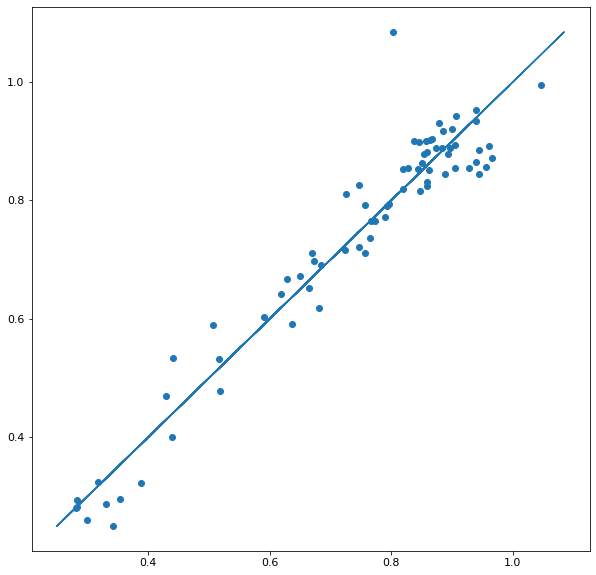

In [22]:
from src.svgp import MultiResolutionVBagg
k=0
train_indices = shuffled_indices[:k*75] + shuffled_indices[(k+1)*75:]
test_indices = shuffled_indices[k*75: (k+1)*75]
train_set = create_spatial_data_dict(data, df, train_indices, max_VOD, max_EVI)
test_set = create_spatial_data_dict(data, df, test_indices, max_VOD, max_EVI)

## SVGP
train_bag = MultiResolutionBagDataGenerator(train_set)

# initialise by 1 element from each bag
zs = np.zeros((train_bag.num_bags, train_bag.dim_space))
z1 = np.zeros((train_bag.num_bags, train_bag.dim_1))
kmeanss = KMeans(n_clusters=1)
kmeans1 = KMeans(n_clusters=1)
print("Calculating Inducing Points")
for i, bag in tqdm(enumerate(train_bag.bags)):
    zs[i, :] = kmeanss.fit(train_bag[bag][4][:train_bag[bag][0]]).cluster_centers_
    z1[i, :] = kmeans1.fit(train_bag[bag][5][:train_bag[bag][1]]).cluster_centers_

ks = gpflow.kernels.Matern32()
k1 = gpflow.kernels.SquaredExponential(active_dims=[i for i in range(213)])
k2 = gpflow.kernels.SquaredExponential(active_dims=[i for i in range(213, 226)])
ds_train = tf.data.Dataset.from_generator(
    train_bag.gen_bags, 
    output_types=(
        tf.int64, 
        tf.int64, 
        tf.float64, 
        tf.float64, 
        tf.float64, 
        tf.float64, 
        tf.float64
    )
)
m = MultiResolutionVBagg((ks, k1+k2), gpflow.likelihoods.Gaussian(), z1=zs, z2=z1,num_data=train_bag.num_bags)

# We turn off training for inducing point locations
gpflow.set_trainable(m.z1, False)
gpflow.set_trainable(m.z2, False)

test_bag = MultiResolutionBagDataGenerator(test_set)

maxiter = 20000
print("Begin Training")
t0 = time.time()
logf = run_adam(m, test_bag, ds_train, N=train_bag.num_bags, iterations=maxiter, minibatch_size=5)
t1 = time.time()

y_pred = np.zeros(test_bag.num_bags)
y_std = np.zeros(test_bag.num_bags)
for i, bag in enumerate(test_set.keys()):
    mean_pred = m.predict_f(np.expand_dims(test_bag[bag][2], axis=0),
                            np.expand_dims(test_bag[bag][4], axis=0), 
                            np.expand_dims(test_bag[bag][3], axis=0), 
                            np.expand_dims(test_bag[bag][5], axis=0))
    y_pred[i] = mean_pred[0]
    y_std[i] = np.sqrt(mean_pred[1])
lower = np.reshape(1.96 * y_std, (test_bag.num_bags, 1))
upper = np.reshape(1.96 * y_std, (test_bag.num_bags, 1))
print(lower.shape, upper.shape)
errors = np.concatenate((lower, upper), axis=1)
errors = errors.T


# plot predictions out-of-sample and save them
plt.figure(figsize=(10, 10))
plt.scatter(y_pred, test_bag.y)
plt.plot(test_bag.y, test_bag.y)
MAPE.append(np.mean(np.abs(( y_pred - test_bag.y[:, 0] ) / test_bag.y[:, 0])))
RMSE.append(np.sqrt(np.mean((y_pred - test_bag.y[:, 0]) ** 2)))
training_time.append(t1-t0)

plt.errorbar(
    y_pred,
    test_bag.y,
    xerr=errors,
    fmt="o",
    ls="none",
    capsize=5,
    markersize=4,
    color="blue",
)
print("Training Time", t1-t0)

In [23]:
covered_95 = 0
covered_80 = 0
for i in range(len(y_pred)):
    if (test_bag.y[i,0] >= y_pred[i] - 1.96 * y_std[i]) & (test_bag.y[i,0] <= y_pred[i] + 1.96 * y_std[i]):
        covered_95 += 1
    
    if (test_bag.y[i,0] >= y_pred[i] - 1.28 * y_std[i]) & (test_bag.y[i,0] <= y_pred[i] + 1.28 * y_std[i]):
        covered_80 += 1

In [24]:
print(f"95% coverage: {covered_95 / 75}, 80% coverage {covered_80 / 75}")

95% coverage: 0.8266666666666667, 80% coverage 0.64


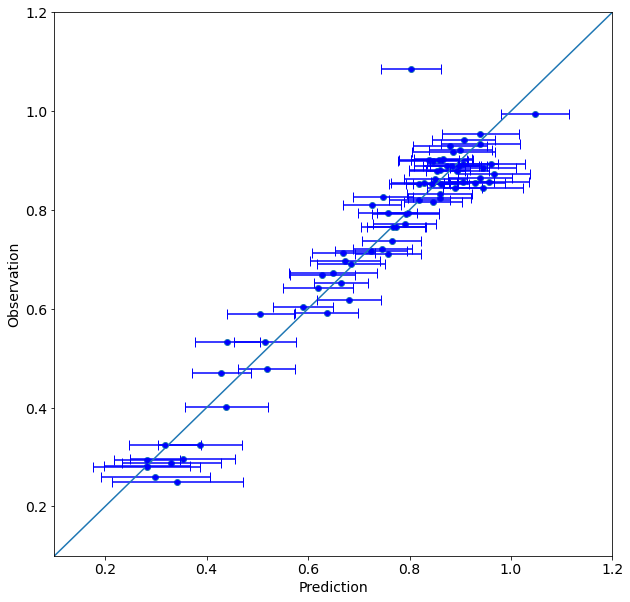

In [31]:
# plot predictions out-of-sample and save them
pars = {"size": 14}
plt.rc("font", **pars)
plt.figure(figsize=(10, 10))
plt.scatter(y_pred, test_bag.y)
plt.plot([0, 2], [0, 2])
plt.errorbar(
    y_pred,
    test_bag.y,
    xerr=errors,
    fmt="o",
    ls="none",
    capsize=5,
    markersize=4,
    color="blue",
)
plt.axis([0.1, 1.2, 0.1, 1.2])
plt.xlabel("Prediction")
plt.ylabel("Observation")
plt.savefig(f"../../results/dr_paper/predVobs_plot.pdf", bbox_inches="tight")

## Disaggregation


Calculating Inducing Points



Begin Training


EPOCH: 0, ELBO: -996.9034283328267, Test RMSE: 0.7601012685920582            MAPE: 0.9958989234744942
EPOCH: 1000, ELBO: -401.930865955712, Test RMSE: 0.07289353223751203            MAPE: 0.07632404220355499
EPOCH: 2000, ELBO: -212.37985190941797, Test RMSE: 0.05266534165418848            MAPE: 0.049962081535847094
EPOCH: 3000, ELBO: 8.429343678701208, Test RMSE: 0.04868306147656893            MAPE: 0.048782786369323525
EPOCH: 4000, ELBO: 182.5701197139185, Test RMSE: 0.049178700704032255            MAPE: 0.04596783224376697
EPOCH: 5000, ELBO: 322.7024534682273, Test RMSE: 0.050371237734990554            MAPE: 0.0434881070629394
EPOCH: 6000, ELBO: 350.5567112825259, Test RMSE: 0.04759989045633666            MAPE: 0.04035438997522715
EPOCH: 7000, ELBO: 448.19509605536496, Test RMSE: 0.04732892849355795            MAPE: 0.03970237121373096
EPOCH: 8000, ELBO: 473.84863106382795, Test RMSE: 0.0455366439831875            MAPE: 0.039704151770827915
EPOCH: 9000, ELBO: 456.9863769436805, Test 

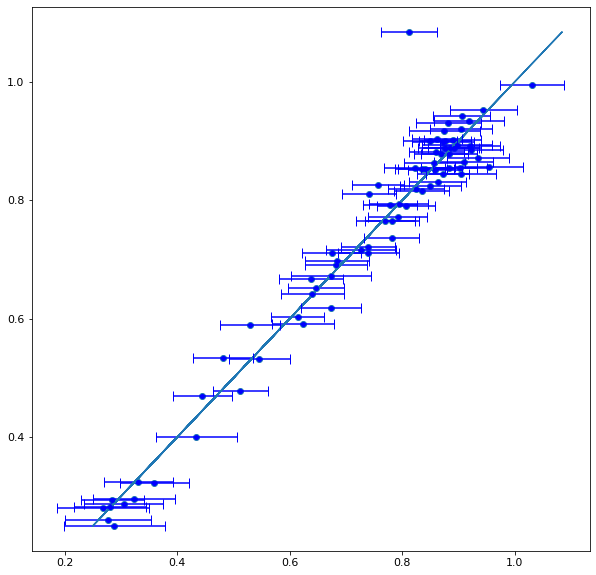

In [72]:
k=0
train_indices = shuffled_indices.copy()
test_indices = shuffled_indices[k*75: (k+1)*75]
train_set = create_spatial_data_dict(data, df, train_indices, max_VOD, max_EVI)
test_set = create_spatial_data_dict(data, df, test_indices, max_VOD, max_EVI)

## SVGP
train_bag = MultiResolutionBagDataGenerator(train_set)

# initialise by 1 element from each bag
zs = np.zeros((train_bag.num_bags, train_bag.dim_space))
z1 = np.zeros((train_bag.num_bags, train_bag.dim_1))
kmeanss = KMeans(n_clusters=1)
kmeans1 = KMeans(n_clusters=1)
print("Calculating Inducing Points")
for i, bag in tqdm(enumerate(train_bag.bags)):
    zs[i, :] = kmeanss.fit(train_bag[bag][4][:train_bag[bag][0]]).cluster_centers_
    z1[i, :] = kmeans1.fit(train_bag[bag][5][:train_bag[bag][1]]).cluster_centers_

ks = gpflow.kernels.Matern32()
k1 = gpflow.kernels.SquaredExponential(active_dims=[i for i in range(213)])
k2 = gpflow.kernels.SquaredExponential(active_dims=[i for i in range(213, 226)])
ds_train = tf.data.Dataset.from_generator(
    train_bag.gen_bags, 
    output_types=(
        tf.int64, 
        tf.int64, 
        tf.float64, 
        tf.float64, 
        tf.float64, 
        tf.float64, 
        tf.float64
    )
)
m = MultiResolutionVBagg((ks, k1+k2), gpflow.likelihoods.Gaussian(), z1=zs, z2=z1,num_data=train_bag.num_bags)

# We turn off training for inducing point locations
gpflow.set_trainable(m.z1, False)
gpflow.set_trainable(m.z2, False)

test_bag = MultiResolutionBagDataGenerator(test_set)

maxiter = 20000
print("Begin Training")
t0 = time.time()
logf = run_adam(m, test_bag, ds_train, N=train_bag.num_bags, iterations=maxiter, minibatch_size=5)
t1 = time.time()

y_pred = np.zeros(test_bag.num_bags)
y_std = np.zeros(test_bag.num_bags)
for i, bag in enumerate(test_set.keys()):
    mean_pred = m.predict_f(np.expand_dims(test_bag[bag][2], axis=0),
                            np.expand_dims(test_bag[bag][4], axis=0), 
                            np.expand_dims(test_bag[bag][3], axis=0), 
                            np.expand_dims(test_bag[bag][5], axis=0))
    y_pred[i] = mean_pred[0]
    y_std[i] = np.sqrt(mean_pred[1])
lower = np.reshape(1.96 * y_std, (test_bag.num_bags, 1))
upper = np.reshape(1.96 * y_std, (test_bag.num_bags, 1))
print(lower.shape, upper.shape)
errors = np.concatenate((lower, upper), axis=1)
errors = errors.T


# plot predictions out-of-sample and save them
plt.figure(figsize=(10, 10))
plt.scatter(y_pred, test_bag.y)
plt.plot(test_bag.y, test_bag.y)
MAPE.append(np.mean(np.abs(( y_pred - test_bag.y[:, 0] ) / test_bag.y[:, 0])))
RMSE.append(np.sqrt(np.mean((y_pred - test_bag.y[:, 0]) ** 2)))
training_time.append(t1-t0)

plt.errorbar(
    y_pred,
    test_bag.y,
    xerr=errors,
    fmt="o",
    ls="none",
    capsize=5,
    markersize=4,
    color="blue",
)
print("Training Time", t1-t0)

In [75]:
xs = np.zeros((0, 2))
for i, bag in enumerate(train_bag.bags):
    xs = np.vstack([xs, train_bag[bag][4]])
    
df_s = gpd.GeoDataFrame(np.concatenate([xs, m.predict_f_z1(xs)[0].numpy()], axis=1), columns=["lat", "long", "pred"])
df_s["geometry"] = df_s.apply(lambda x: Point(x["lat"], x["long"]),axis=1)
df_s.crs = 4326
df_s = df_s.to_crs(3857)

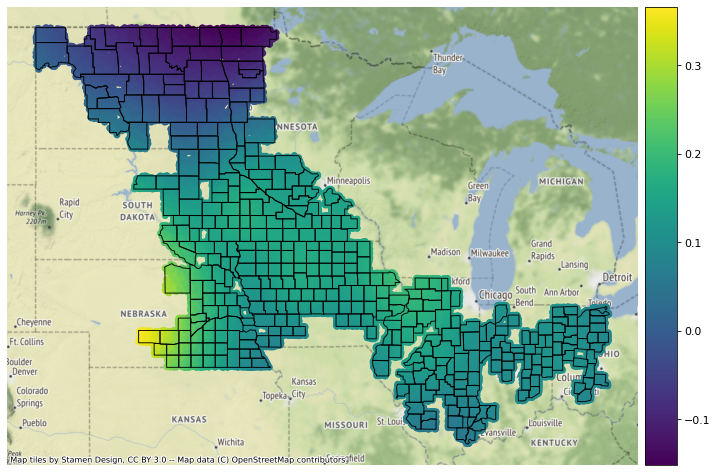

In [76]:
df_plot = df.to_crs(epsg=3857)
pars = {"size": 11}
plt.rc("font", **pars)
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
# ax.scatter(xs[:,0], xs[:,1], c=m.predict_f_zs(xs)[0].numpy())
df_s.plot(column="pred", ax=ax, cax=cax, legend=True, cmap="viridis")
df_plot.plot(ax=ax, facecolor="none",
            edgecolor='k', alpha=0.9)
ax.set_aspect("equal")
# ax1.set_xlim([-1.04e7, -0.94e7])
ctx.add_basemap(ax)
ax.axis('off')
fig.savefig(f"../../results/dr_paper/indiv_pred_s.pdf", bbox_inches="tight")